In [96]:
import pandas as pd

In [97]:
# mount the drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [98]:
# Retrieve the data in the csv file
data_csv = pd.read_csv("/content/gdrive/MyDrive/MASTER/ETTh1_without_missing.csv")

#show the shape of the dataset
data_csv.shape
# We get (17320,4) meaing 4 columns and 17320 datapoint

(17320, 4)

In [99]:
# Names of columns are :
data_csv.columns

#Index(['Id', 'date', 'OT', 'Unnamed: 3'], dtype='object')

Index(['Id', 'date', 'OT', 'Unnamed: 3'], dtype='object')

In [100]:
from datetime import datetime

# Convert to datetime
def convert_to_datetime(dataset):
    # Create new dataframe so as to keep our original dataframe safe
    df = dataset.copy()

    try:
        df["date"] = pd.to_datetime(df["date"])
    except KeyError as e:
        print(f"Error: {e}. Make sure 'date' column exists in your dataset.")

    return df

In [101]:
# Create a copy of the dataset
new_dataset = convert_to_datetime(data_csv)
# Remove the empty column in case the prediction is affected by it
new_dataset.drop(['Id', 'Unnamed: 3'], axis = 1, inplace = True)
new_dataset.head()

,date,OT
0,2016-07-01 00:00:00,30.531000
1,2016-07-01 01:00:00,27.787001
2,2016-07-01 02:00:00,27.787001
3,2016-07-01 03:00:00,25.044001
4,2016-07-01 04:00:00,21.948000


check for if data is stationary

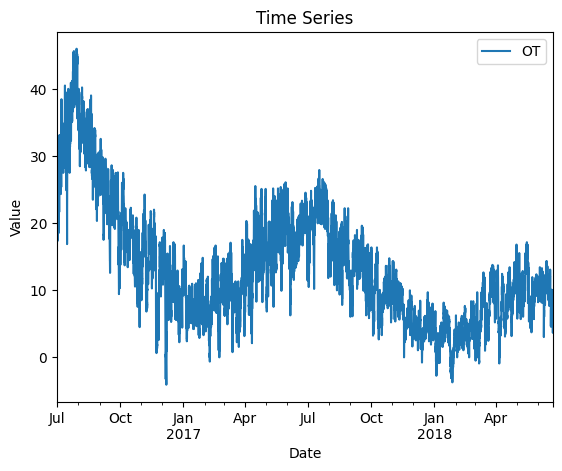

Results of Dickey-Fuller Test:
Test Statistic                    -3.435037
p-value                            0.009821
#Lags Used                        44.000000
Number of Observations Used    17275.000000
Critical Value (1%)               -3.430729
Critical Value (5%)               -2.861707
Critical Value (10%)              -2.566859
dtype: float64


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

temp_dataset = new_dataset.copy()

# Set date column as the index
temp_dataset.set_index('date', inplace=True)

# Visual inspection for stationarity
temp_dataset.plot()
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Performing the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Apply the function to your data
test_stationarity(temp_dataset['OT'])


OUR DATASET IS STATIONARY ::: let's test seasonality

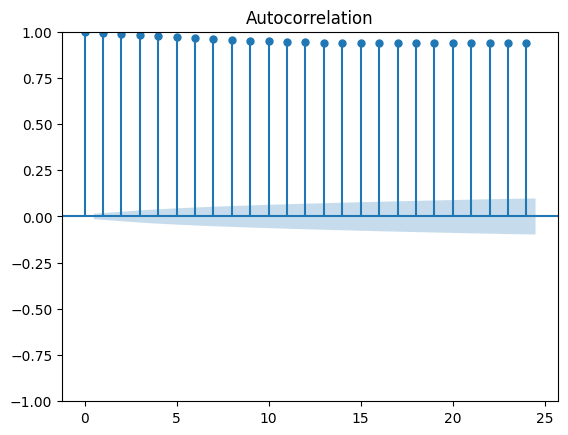

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(temp_dataset['OT'], lags=24)  # Adjust 'lags' based on the expected seasonal periods
plt.show()

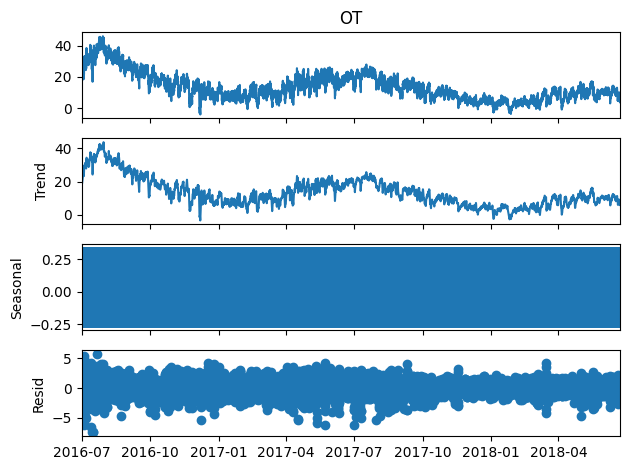

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
# Choose model='additive' or model='multiplicative' based on your time series characteristics
decomposition = seasonal_decompose(temp_dataset['OT'], model='additive', period=12)  # period depends on the data's frequency

# Plot the decomposed components
fig = decomposition.plot()
plt.show()

In [15]:
#Detrend
from scipy.signal import savgol_filter

window_length = 5  # Adjust window length based on data characteristics
poly_order = 2  # Polynomial order
detrended_data = savgol_filter(temp_dataset['OT'], window_length, poly_order)

In [52]:
# convert to list
detrended = detrended_data.tolist()

In [84]:
df=new_dataset.copy()
df["detrended_OT"] = detrended

In [487]:
#delete the first 7000 values
df=new_dataset.copy()
df["detrended_OT"] = detrended
# Choose a window size for smoothing
window_size = 3

# Apply a simple moving average (SMA)
df['OT_SMA'] = df['detrended_OT'].rolling(window=window_size, center=True).mean()

amt_data = 4427   #5101 24*38 0.448
df = df.iloc[amt_data:]

In [488]:
df = df.dropna()

In [489]:
df.head(300)

,date,OT,detrended_OT,OT_SMA
4427,2017-01-01 11:00:00,12.029000,11.209143,11.483219
4428,2017-01-01 12:00:00,11.889000,12.630343,12.793743
4429,2017-01-01 13:00:00,14.632000,14.541743,14.471953
4430,2017-01-01 14:00:00,16.672001,16.243772,15.420591
4431,2017-01-01 15:00:00,15.476000,15.476257,15.200162
...,...,...,...,...
4722,2017-01-13 18:00:00,10.974000,10.962086,10.773771
4723,2017-01-13 19:00:00,10.482000,10.735029,10.767838
4724,2017-01-13 20:00:00,10.763000,10.606400,10.456276
4725,2017-01-13 21:00:00,10.130000,10.027400,9.815771


In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12892 entries, 4427 to 17318
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          12892 non-null  datetime64[ns]
 1   OT            12892 non-null  float64       
 2   detrended_OT  12892 non-null  float64       
 3   OT_SMA        12892 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 503.6 KB


In [491]:
# Reindexing
df = df.reset_index(drop=True)
from statsmodels.tsa.ar_model import AutoReg
l = 24*38
# Fit an AR(l) model
# The `lags=1` parameter indicates an AR(1) model
model = AutoReg(df['OT_SMA'], lags=l) #BEST parameters 221 24*32 0.49 (best ever non deleted with 24*38 0.93)
model_fitted = model.fit()

# Print out the summary of the fit
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:                 OT_SMA   No. Observations:                12892
Model:                   AutoReg(912)   Log Likelihood                9139.133
Method:               Conditional MLE   S.D. of innovations              0.113
Date:                Fri, 15 Mar 2024   AIC                         -16450.265
Time:                        20:55:02   BIC                          -9694.897
Sample:                           912   HQIC                        -14184.000
                                12892                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0031      0.002      1.304      0.192      -0.002       0.008
OT_SMA.L1       2.9437      0.009    322.129      0.000       2.926       2.962
OT_SMA.L2      -3.4354      0.028   -120.919    

In [492]:
from datetime import datetime, timedelta

max_date = df["date"].max()
print(max_date)

s_date = pd.Timestamp(max_date)

start_date = s_date + pd.Timedelta(hours=1)
last_date = s_date + pd.Timedelta(hours=101)

print(f"start_date: {start_date}, last_date :{last_date}")

2018-06-22 14:00:00
start_date: 2018-06-22 15:00:00, last_date :2018-06-26 19:00:00


In [494]:
start = len(df)
print(start)
end = start + 101
forecast_values = model_fitted.predict(start=start, end=end, dynamic=False)
print(forecast_values)

12892
12892     4.915540
12893     5.967533
12894     6.359488
12895     6.274126
12896     5.876882
           ...    
12989    10.227539
12990    10.062934
12991     9.787710
12992     9.538830
12993     9.340835
Length: 102, dtype: float64


In [495]:
# Drop the first value since we already have it
forecast_value = forecast_values[2:]
print(forecast_values)

12892     4.915540
12893     5.967533
12894     6.359488
12895     6.274126
12896     5.876882
           ...    
12989    10.227539
12990    10.062934
12991     9.787710
12992     9.538830
12993     9.340835
Length: 102, dtype: float64


In [496]:
#Convert forecast_values to a list
forecast_values = forecast_value.tolist()

In [497]:
# REAL VALUES
real_values_dataset = pd.read_csv("/content/gdrive/MyDrive/MASTER/next.csv")
real_values_dataset.head(20)

,date,OT
0,2018-06-22 16:00:00,5.979
1,2018-06-22 17:00:00,4.362
2,2018-06-22 18:00:00,4.643
3,2018-06-22 19:00:00,5.839
4,2018-06-22 20:00:00,5.909
5,2018-06-22 21:00:00,5.979
6,2018-06-22 22:00:00,5.839
7,2018-06-22 23:00:00,5.839
8,2018-06-23 00:00:00,5.346
9,2018-06-23 01:00:00,5.417


In [498]:
# ADD a colum
real_values_dataset["estimated_OT"] = forecast_values
real_values_dataset.head(20)

,date,OT,estimated_OT
0,2018-06-22 16:00:00,5.979,6.359488
1,2018-06-22 17:00:00,4.362,6.274126
2,2018-06-22 18:00:00,4.643,5.876882
3,2018-06-22 19:00:00,5.839,5.666467
4,2018-06-22 20:00:00,5.909,5.501849
5,2018-06-22 21:00:00,5.979,5.437595
6,2018-06-22 22:00:00,5.839,5.413852
7,2018-06-22 23:00:00,5.839,5.398994
8,2018-06-23 00:00:00,5.346,5.364677
9,2018-06-23 01:00:00,5.417,5.357788


In [499]:
from sklearn.metrics import mean_absolute_error
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(real_values_dataset['OT'], real_values_dataset['estimated_OT'])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.44398265570183054


In [316]:
id = [i for i in range(100)]
predicted_AR = pd.DataFrame(id, columns=['Id'])
predicted_AR['OT'] = forecast_values

In [ ]:
predicted_AR.head(10)

,Id,OT
0,0,6.670344
1,1,5.909956
2,2,5.693313
3,3,5.407250
4,4,5.296992
5,5,5.351746
6,6,5.400136
7,7,5.379639
8,8,5.311542
9,9,5.269332


In [ ]:
predicted_AR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      100 non-null    int64  
 1   OT      100 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


In [ ]:
predicted_AR.to_csv('out.csv')